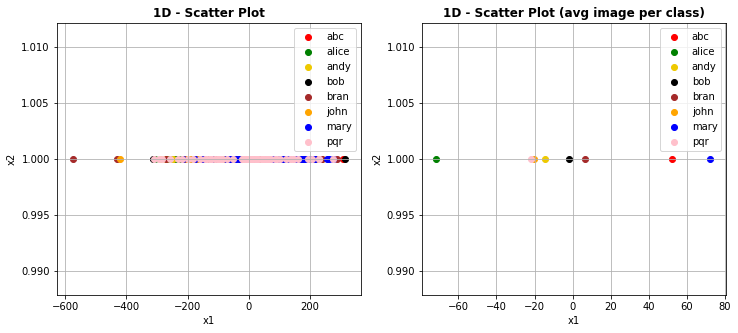

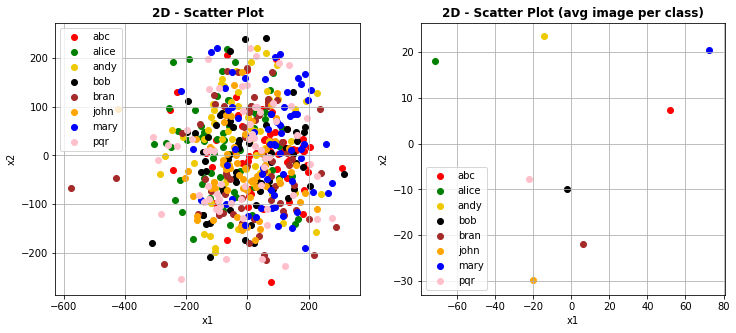

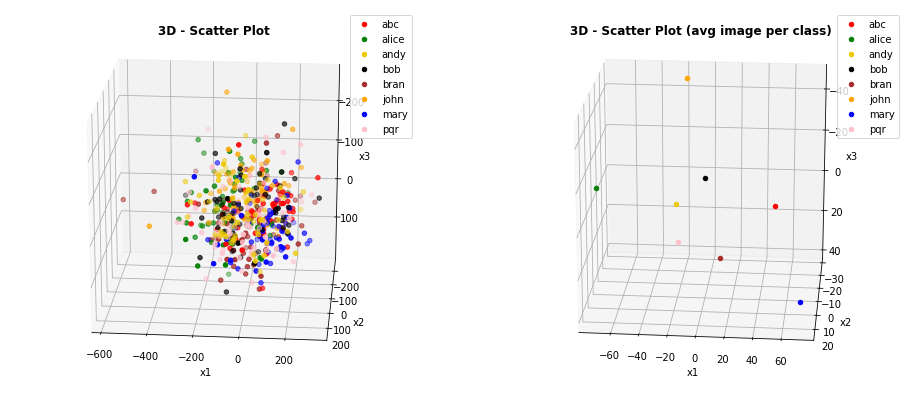

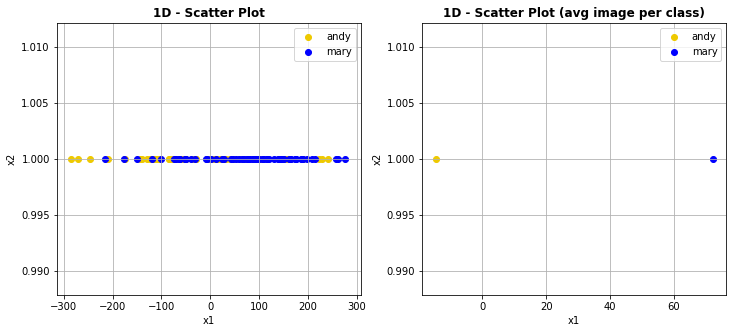

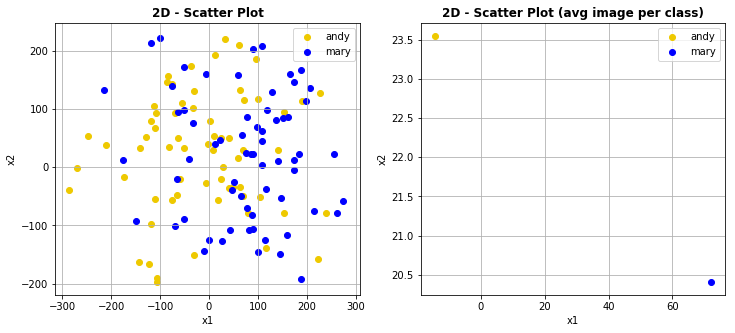

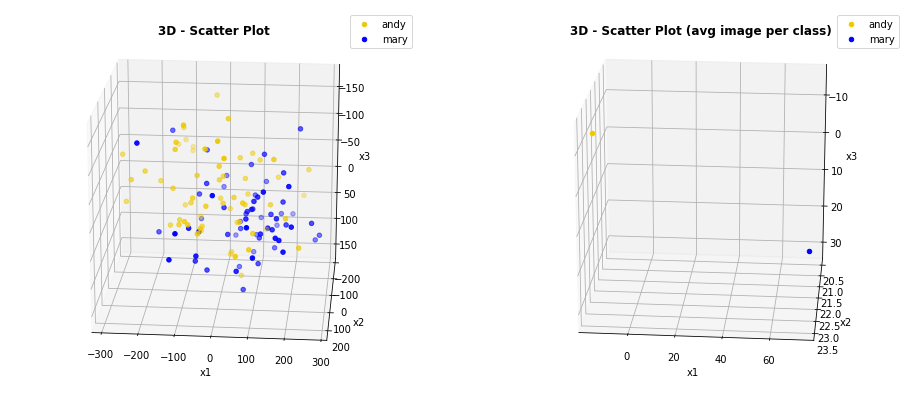

principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %
	 1 		 2159.01625 	     10.57754 		 62.53699 	  49586.34771 	    75.66276
Images - constructed with 1 principal components:
------------------------------------------------


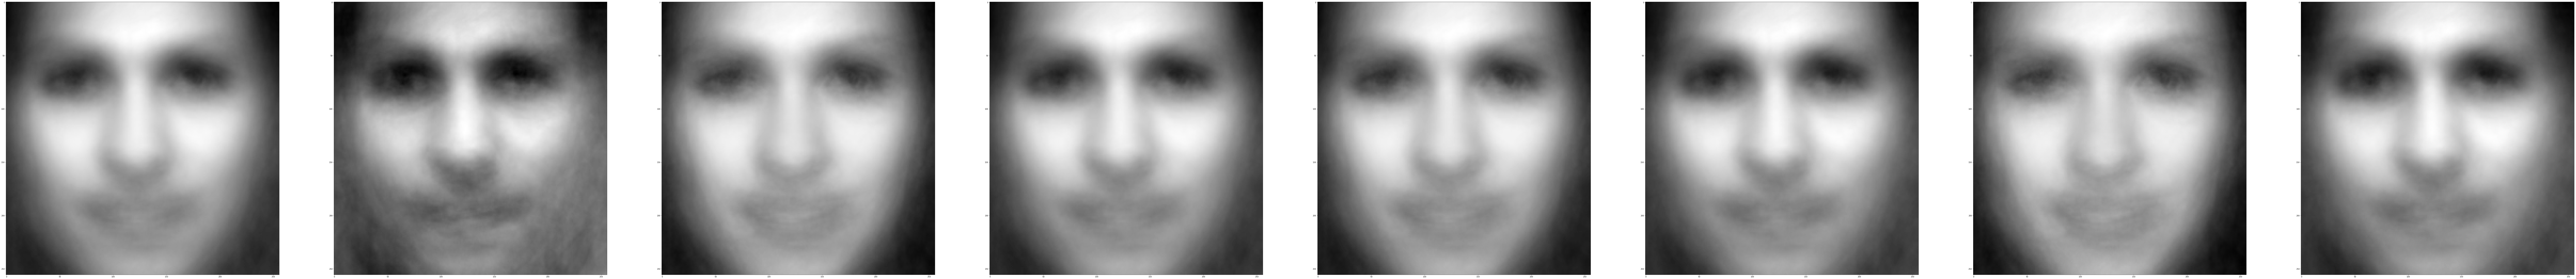

principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %
	 2 		 1722.53364 	     8.43911 		 85.66855 	  39886.04642 	    60.86128
Images - constructed with 2 principal components:
------------------------------------------------


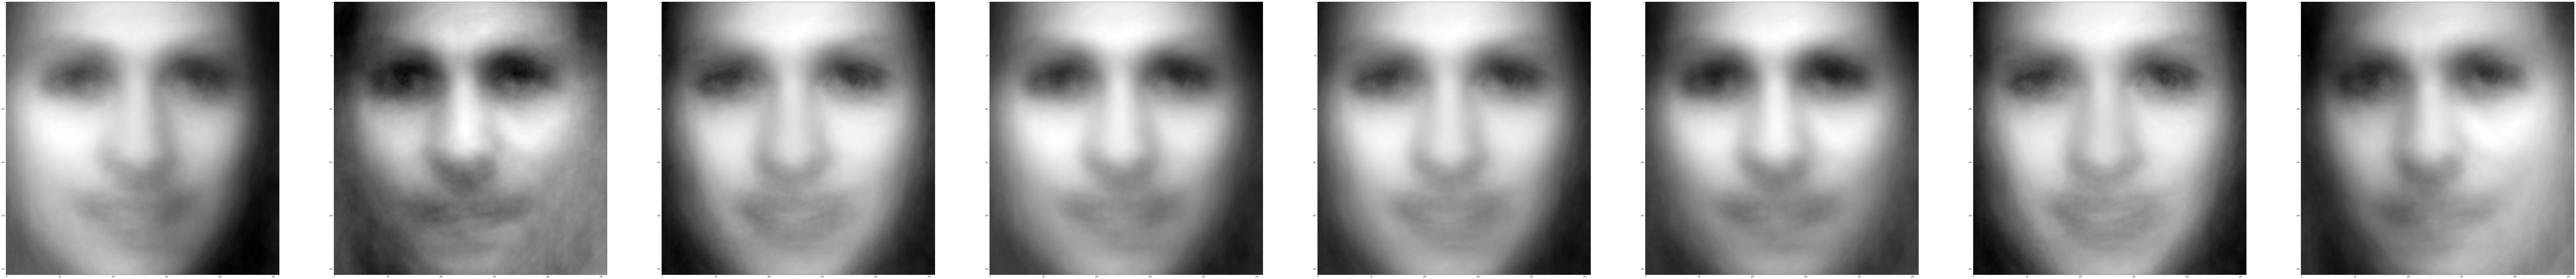

principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %
	 3 		 1464.34288 	     7.17417 		 91.21182 	  35137.4464 	    53.61549
Images - constructed with 3 principal components:
------------------------------------------------


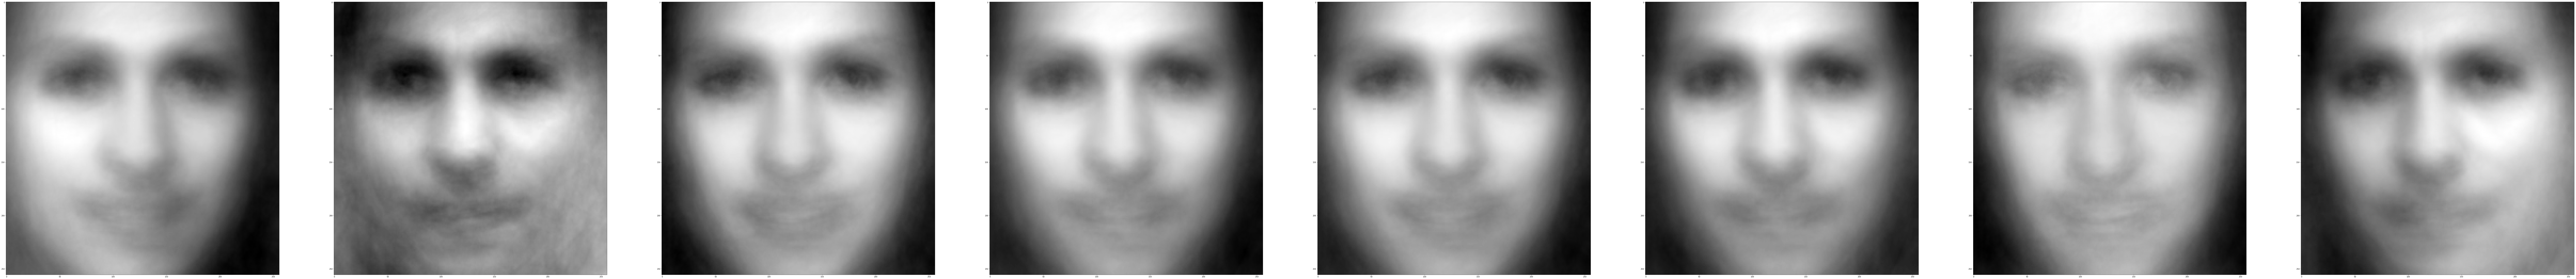

principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %


PermissionError: [Errno 13] Permission denied: 'pca_results.csv'

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from psutil import virtual_memory
import numpy as np
import pandas as pd
%matplotlib inline
#get_ipython().magic(u'matplotlib inline')

def normalize(X):
    mu = np.mean(X, axis=0)
    std=None
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = np.zeros(X.shape)
    for row in range(X.shape[0]):
        #Xbar[row,:]=(X[row,:]-mu)
        Xbar[row,:]=(X[row,:]-mu)/std_filled
    return Xbar, mu, std

def eig(S):
    eig_vals, eig_vecs = np.linalg.eig(S)
    index_array=np.argsort(-eig_vals)
    sorted_eig_vals=eig_vals[index_array]
    sorted_eig_vecs=eig_vecs[:,index_array] #sorted eigen vectors
    return (sorted_eig_vals, sorted_eig_vecs)

def normalize_by_col(U):
    #U_T = [vec/np.linalg.norm(vec) for vec in U.T]
    #U_T = np.asarray(U_T)
    #U = U_T.T
    #OR
    for i in range(len(U.T)):
        U.T[i]=U.T[i]/np.linalg.norm(U.T[i])
        
    #print("DOT PRO: ",U.T[0]@U.T[1])
    #print("norm: ",np.linalg.norm(U.T[3]))
    return U

def total_variance(eigvals):
    return np.square(eigvals).sum()

def variance_captured(eigvals, num_components):
    return np.square(eigvals[0:num_components]).sum()

def variance_captured_by_component_wise(X):
    Xbar, mu, std = normalize(X)
    var_by_component = list()
    N,D = X.shape
    O=(1/N)*(Xbar@Xbar.T) #since X^TX is a huge matrix. Compute XX^T and find its eigen vectors
    eig_vals, eig_vecs = eig(O)
    tot_var=total_variance(eig_vals)
    for i in range(len(eig_vals)):
        kth_variance = np.square(eig_vals[i])
        var_captured_by_kth_comp = (kth_variance/tot_var)*100
        var_by_component.append((i+1,var_captured_by_kth_comp))
    var_by_component = np.asarray(var_by_component)
    return var_by_component
    

def pca(X,num_components):
    Xbar, mu, std = normalize(X)
    N,D = X.shape
    O=(1/N)*(Xbar@Xbar.T) #since X^TX is a huge matrix. Compute XX^T and find its eigen vectors
    eig_vals, eig_vecs = eig(O) # compute the eigenvalues of O
    U = Xbar.T @ eig_vecs # Compute the eigenvectors for the original XX^T.
    U = normalize_by_col(U) #normalize eigen vectors of original covariance; This is the principal basis
    U = U[:,0:num_components] #picking eigen vectors corresponding to large eigen values (top num_components)
    Z=Xbar@U #new vector in lower dimensional subspace i.e., coeffs in 'num_components-dimensional space
    reconstructed_data=Z@U.T #reconstructed data
    centered_loss = np.square(Xbar - reconstructed_data).sum(axis=1).mean() #average loss
    centered_loss_percent = ((np.square(reconstructed_data - Xbar).sum(axis=1).mean())/(np.square(Xbar).sum(axis=1).mean()))*100
    var_captured_percent = ((np.square(eig_vals[0:num_components]).sum())/(np.square(eig_vals).sum()))*100
    reconstructed_data=reconstructed_data*std+mu.T
    original_loss = np.square(X - reconstructed_data).sum(axis=1).mean() #average loss
    original_loss_percent = ((original_loss)/(np.square(X).sum(axis=1).mean()))*100
    return Z, U, reconstructed_data, centered_loss, centered_loss_percent, var_captured_percent, original_loss, original_loss_percent #z-principal components, U-principal basis

def print_record(num_component, original_loss, original_loss_percent, var_captured_percent, centered_loss, centered_loss_percent):
    print('\t',num_component,'\t\t',np.round(original_loss,5),'\t    ', np.round(original_loss_percent,5),'\t\t', np.round(var_captured_percent,5),'\t ', np.round(centered_loss,5),'\t   ', np.round(centered_loss_percent,5))
    
def print_header():
    print('principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %'.format())
    
def calibrate_numcomponents(X):
    loss_records = []
    original_loss_records = []
    reconstructions = []
    losspercentages = []
    originallosspercentages = []
    var_captured_percentages = []
    var_captured_percentages.append((0,0)) #dummy: for graph purpose
    curr_num_components = 0
    log_records=[]
    print_header()
    for num_component in range(1, 4):
        curr_num_components = num_component
        principal_components, principal_basis, reconstructed_data, centered_loss, centered_loss_percent, var_captured_percent, original_loss, original_loss_percent = pca(X, num_component)
        #print("principal_components SHAPE: ",principal_components.shape)
        #error = mse(reconst, Xbar)
        #reconstructions.append(reconstructed_data)
        #print('No. of principal components = {:d}, original_loss = {:f}, original_loss_percent = {:f}, var_captured_percent = {:f}, centered_loss = {:f}, centered_loss_percent = {:f}'.format(num_component, original_loss, original_loss_percent, var_captured_percent, centered_loss, centered_loss_percent))
        #print('principal comps (k) |   original_loss   | original_loss % | var_captured % |    centered_loss    | centered_loss %'.format())
        #print('\t',num_component,'\t\t',round(original_loss,5),'\t    ', round(original_loss_percent,5),'\t\t', round(var_captured_percent,5),'     ', round(centered_loss,5),'       ', round(centered_loss_percent,5))
        
        print_record(num_component, original_loss, original_loss_percent, var_captured_percent, centered_loss, centered_loss_percent)
        if(num_component>=1 or num_component==5 or num_component==10 or num_component == 32 or num_component >= 518  or num_component%50==0):
            print("Images - constructed with {:d} principal components:".format(num_component))
            print("------------------------------------------------".format(num_component))
            show_images(reconstructed_data)
            print_header()
        log_records.append(tuple((num_component, original_loss, original_loss_percent, var_captured_percent, centered_loss, centered_loss_percent)))
        loss_records.append((num_component, centered_loss))
        original_loss_records.append((num_component, original_loss))
        losspercentages.append((num_component, centered_loss_percent))
        originallosspercentages.append((num_component,original_loss_percent))
        var_captured_percentages.append((num_component, var_captured_percent))
        #if(loss_percent < 20):
            #break
        #reconstructions = np.asarray(reconstructions)
    #reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
    df=pd.DataFrame(data=log_records,columns=['No. of Principal Components','Original Loss','Original Loss Percent','Variance Captured Percentage','Centered Loss','Centered Loss Percent'])
    df.to_csv("pca_results.csv",sep=',', encoding='utf-8',index=False)

    loss_records = np.asarray(loss_records)
    losspercentages = np.asarray(losspercentages)
    original_loss_records = np.asarray(original_loss_records)
    originallosspercentages = np.asarray(originallosspercentages)
    var_captured_percentages = np.asarray(var_captured_percentages)
    return loss_records, losspercentages, original_loss_records, originallosspercentages, curr_num_components, var_captured_percentages
    
def load_data(file_name):
    input_file=open(file_name, "r")
    #TODO: try reading file using buffers instead reading all the contents at a time
    lines = [line.strip('\n') for line in input_file]
    y=list()
    data=list()
    for line in lines:
        image_path  = line.split()[0]
        image_label  = line.split()[1]
        y.append(image_label)
        pic = Image.open(image_path)
        pic = pic.convert('L')
        datapoint = np.array(pic)
        datapoint = datapoint.flatten()
        data.append(datapoint)
    
    data=np.array(data)
    labels=np.array(y)
    NUM_DATAPOINTS = data.shape[0]
    data = (data.reshape(-1, 256 * 256)[:NUM_DATAPOINTS]) / 255
    return data,labels

def plot_mse_vs_num_pcs(loss, lineat=None, ylabel="", title=""):
    fig, ax = plt.subplots()
    ax.plot(loss[:,0], loss[:,1], color='green');
    if(lineat != None):
        ax.axhline(lineat, linestyle='--', color='r', linewidth=2, label="MSE% = 19.86% (just < 20) at k=32")
    ax.xaxis.set_ticks(np.arange(1, 520, 50));
    ax.set(xlabel='No. of principal components (k)', ylabel=ylabel, title=title);
    plt.title(title,fontweight='bold')
    plt.legend()
    plt.grid()
    plt.show()

def plot_variance_contribution_vs_kth_pc(variance_fraction, lineat=None, ylabel="", title=""):
    fig, ax = plt.subplots()
    ax.plot(variance_fraction[:,0], variance_fraction[:,1]);
    ax.yaxis.set_ticks(np.arange(0, 65, 10));
    ax.xaxis.set_ticks(np.arange(0, 11, 1));
    ax.set(xlabel='kth principal component', ylabel=ylabel, title=title);
    plt.title(title,fontweight='bold')
    ax.set_ylim(0,65)
    ax.set_xlim(1,10) #negligible variance conribution after k=100
    plt.grid()
    plt.show()

def plot_variance_captured_with_k_pcs(variance_captured, ylabel="", title=""):
    fig, ax = plt.subplots()
    ax.plot(variance_captured[:,0], variance_captured[:,1]);
    ax.yaxis.set_ticks(np.arange(0, 100, 10));
    ax.xaxis.set_ticks(np.arange(0, 31, 5));
    #ax.set(xlabel='Number of principal components (k)', ylabel=ylabel, title=title, fontweight='bold');
    ax.set(xlabel='Number of principal components (k)', ylabel=ylabel);
    ax.set_ylim(0,101)
    ax.set_xlim(0,32) #negligible variance conribution after k=100
    plt.title(title,fontweight='bold')
    plt.grid()
    plt.show()
    
def show_images(reconstructed_data):
    #idxs=[1,1,1,1,1,1,1,1]
    fig, ax = plt.subplots(figsize=(256,256))
    #idxs=[5,27,12,13,21,8,55,51]
    idxs=[5,27,12,13,21,8,45,51]
    for j in  range(len(idxs)):
        plt.subplot(1,8,j+1)
        plt.imshow(reconstructed_data[j*65+idxs[j]].reshape((256,256)),cmap="gray")
    plt.show()
    
def show_original_images(data):
    #idxs=[1,1,1,1,1,1,1,1]
    fig, ax = plt.subplots(figsize=(256,256))
    #idxs=[5,27,12,13,21,8,55,51]
    idxs=[5,27,12,13,21,8,45,51]
    for j in  range(len(idxs)):
        plt.subplot(1,8,j+1)
        plt.imshow(data[j*65+idxs[j]].reshape((256,256,3)))
    plt.show()

def plot_data(Z,labels,classes,colors):
    dims = [1, 2, 3]
    xlabel='x1'
    ylabel='x2'
    zlabel='x3'
    for i in dims:
        if(i==1):
            fig, ax = plt.subplots(figsize=(12,5))
            plt.subplot(1,2,1)
            plot_data_1D(Z,labels,classes,colors,average=False)
            plt.title("1D - Scatter Plot", fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.grid()
            plt.legend()
            plt.subplot(1,2,2)

            plot_data_1D(Z,labels,classes,colors,average=True)
            plt.title("1D - Scatter Plot (avg image per class)", fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.grid()
            plt.legend()
            plt.show()
        if(i==2 and Z.shape[1] > 1):
            fig, ax = plt.subplots(figsize=(12,5))
            plt.subplot(1,2,1)
            plot_data_2D(Z,labels,classes,colors,average=False)
            plt.title("2D - Scatter Plot", fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.grid()
            plt.legend()
            plt.subplot(1,2,2)

            plot_data_2D(Z,labels,classes,colors,average=True)
            plt.title("2D - Scatter Plot (avg image per class)", fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.grid()
            plt.legend()
            plt.show()
        if(i==3 and Z.shape[1] > 2):
            #fig, ax = plt.subplots(figsize=(12,5),projection='3d')
            fig = plt.figure(figsize=(16,7))
            ax = fig.add_subplot(121, projection='3d')
            plot_data_3D(Z,labels,classes,colors,ax,average=False)
            plt.title("3D - Scatter Plot", fontweight='bold')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.set_zlabel('x3')
            plt.grid()
            plt.legend()
            #ax.view_init(60,90)
            
            #ax.view_init(60,85)
            #ax.view_init(210,265)
            ax.view_init(200,265)
            #ax.view_init(210,245)
            
            
            #ax.view_init(0,0)
            #ax.view_init(90,0)
            #ax.view_init(30,60)
            ax = fig.add_subplot(122, projection='3d')
            plot_data_3D(Z,labels,classes,colors,ax,average=True)
            plt.title("3D - Scatter Plot (avg image per class)", fontweight='bold')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.set_zlabel('x3')
            ax.view_init(200,265)
            plt.grid()
            plt.legend()
            plt.show()

def plot_some_data(Z,labels,classes,colors):
    Z_limited = list()
    labels_limited = list()
    
        
    for i in range(len(Z)):
        if(labels[i]=='andy' or labels[i]=='mary'):
            #print(' ', labels[i])
            Z_limited.append(Z[i])
            labels_limited.append(labels[i])
    classes=['andy','mary']
    colors={'andy':'#EEC900','mary':'blue'}
    classes=np.asarray(classes)
    #colors=np.asarray(colors)
    Z_limited = np.asarray(Z_limited)
    #print('SHAPE: ',Z_limited.shape)
    labels_limited = np.asarray(labels_limited)
    plot_data(Z_limited,labels_limited,classes,colors)
    
def plot_data_2D(Z,labels,classes,colors,average=False):
    for i in range(len(classes)): #for each class
        class_idxs = np.argwhere(labels==classes[i])
        class_idxs = class_idxs.flatten()
        if(not average):
            plt.scatter(Z[class_idxs][:,0], Z[class_idxs][:,1], color=colors[classes[i]], label=classes[i])
        else:
            mean_for_class = np.mean(Z[class_idxs], axis=0)
            plt.scatter(mean_for_class[0], mean_for_class[1], color=colors[classes[i]], label=classes[i])
            
def plot_data_3D(Z,labels,classes,colors,ax,average=False,):
    for i in range(len(classes)): #for each class
        class_idxs = np.argwhere(labels==classes[i])
        class_idxs = class_idxs.flatten()
        if(not average):
            ax.scatter(Z[class_idxs][:,0], Z[class_idxs][:,1], Z[class_idxs][:,2], color=colors[classes[i]], label=classes[i])
        else:
            mean_for_class = np.mean(Z[class_idxs], axis=0)
            ax.scatter(mean_for_class[0], mean_for_class[1], mean_for_class[2], color=colors[classes[i]], label=classes[i])

def plot_data_1D(Z,labels,classes,colors,average=False):
    for i in range(len(classes)): #for each class
        class_idxs = np.argwhere(labels==classes[i])
        class_idxs = class_idxs.flatten()
        if(len(Z.shape) == 1): #1d array, make it 2d array i.e, [1,2,3] => [[1],[2],[3]]
            Z = Z.reshape((Z.shape[0],1))
        if(not average):
            yvals = np.ones(len(Z[class_idxs])) #dummy
            plt.scatter(Z[class_idxs][:,0], yvals, color=colors[classes[i]], label=classes[i])
        else:
            mean_for_class = np.mean(Z[class_idxs], axis=0)
            plt.scatter(mean_for_class[0], 1, color=colors[classes[i]], label=classes[i])
        
    
    
#1. load and preprocess data
data, labels = load_data("train_set_consol.txt")
#show_original_images(data)
#classes = list(set(labels))
classes = list(np.unique(labels))
colors_pool=["red", "green", "#EEC900", "black", "brown", "orange", "blue", "pink", "navy", "yellow"]
label_map = {}
colors_map = {}
reverse_label_map = {}
for i in range(len(classes)):
    label_map[classes[i]] = i;
    reverse_label_map[i] = classes[i];
    colors_map[classes[i]]=colors_pool[i] #make sure you have enough colors in the pool..as many as number of classes at least
    
#plt.subplot(1,2,2)
#plt.imshow(data[0].reshape((256,256)),cmap="gray")
#plt.show()

num_components = 520
principal_components, principal_basis, reconstructed_data, loss, loss_percent, var_captured_percent, original_loss, original_loss_percent = pca(data, num_components)

plot_data(principal_components,labels,classes,colors_map)
plot_some_data(principal_components,labels,classes,colors_map)


#plt.imshow(reconstructed_data[400].reshape((256,256)),cmap="gray")
#plt.show()

loss_records, losspercentages, original_loss_records, originallosspercentages, curr_num_components, var_captured_percentages = calibrate_numcomponents(data)
#plot_mse_vs_num_pcs(original_loss_records,ylabel='Total MSE',title='Total MSE vs No. of Principal Components\n(On Original Data)')
#plot_mse_vs_num_pcs(loss_records,ylabel='Total MSE',title='Total MSE vs No. of Principal Components\n(On Centered and Std. Data)')

#plot_mse_vs_num_pcs(originallosspercentages,ylabel='MSE(%)',title='MSE(%) vs No. of Principal Components\n(On Original Data)')
#plot_mse_vs_num_pcs(losspercentages,lineat=20,ylabel='MSE(%)',title='MSE(%) vs No. of Principal Components\n(On Centered and Std. Data)')

#variance_by_component = variance_captured_by_component_wise(data)
#plot_variance_contribution_vs_kth_pc(variance_by_component, ylabel="Variance contribution (%)", title="Variance contribution(%) vs kth Principal Component")
#plot_variance_captured_with_k_pcs(var_captured_percentages, ylabel="Variance captured (%)", title="Variance captured(%) vs k Principal Components")


In [ ]:
def load_data(file_name):
    input_file=open(file_name, "r")
    #TODO: try reading file using buffers instead reading all the contents at a time
    lines = [line.strip('\n') for line in input_file]
    y=list()
    data=list()
    for line in lines:
        image_path  = line.split()[0]
        image_label  = line.split()[1]
        y.append(image_label)
        pic = Image.open(image_path)
        pic = pic.convert('L')
        datapoint = np.array(pic)
        datapoint = datapoint.flatten()
        data.append(datapoint)
    data=np.array(data)
    labels=np.array(y)
    NUM_DATAPOINTS = data.shape[0]
    data = (data.reshape(-1, 256 * 256)[:NUM_DATAPOINTS]) / 255
    return data,labels
def show_images(reconstructed_data):
    #idxs=[1,1,1,1,1,1,1,1]
    fig, ax = plt.subplots(figsize=(256,256))
    #idxs=[5,27,12,13,21,8,55,51]
    idxs=[5,27,12,13,21,8,45,51]
    for j in  range(len(idxs)):
        plt.subplot(1,8,j+1)
        plt.imshow(reconstructed_data[j*65+idxs[j]].reshape((256,256)),cmap="gray")
    plt.show()
    
data, labels = load_data("train_set_consol.txt")
show_images(data)

#plt.subplot(1,2,2)
#plt.imshow(data[0].reshape((256,256)),cmap="gray")
#plt.show()

In [ ]:
num_components = 520
principal_components, principal_basis, reconstructed_data, loss, loss_percent, var_captured_percent = pca(data, num_components)

plot_data(principal_components,labels,classes,colors_map)
